In [77]:
import pandas as pd; import geopandas as gpd
import seaborn as sns
from datetime import datetime

import shapely, keplergl

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
youthmappers = json.load(open('/Users/jenningsanderson/youthmappers-analysis/data/userList.json','r'))
youthmappers_names = set([u['u'] for u in youthmappers.values()])

Extract Changeset metadata from the Changeset table on Amazon Athena (OSM PDS)
```sql
SELECT id,
         num_changes,
         created_at,
         "user",
         CAST(tags AS JSON) AS tags,
         min_lon AS min_x,
         max_lon AS max_x,
         min_lat AS min_y,
         max_lat AS max_y
FROM changesets
WHERE lower(tags['created_by']) LIKE '%healthsite%'
```
Saving as 'created-by-healthsite-apr24.csv'

In [79]:
healthsites = pd.read_csv('./data/created-by-healthsite-apr24.csv')
healthsites['date'] = healthsites.created_at.apply(lambda t: pd.Timestamp(t).date())
healthsites['is_ym'] = healthsites.user.apply(lambda u: u in youthmappers_names)
healthsites.head(2)

,id,num_changes,created_at,user,tags,min_x,max_x,min_y,max_y,date,is_ym
0,83616741,1,2020-04-15 23:55:11.000,Abdulhafidh,"{""comment"":"" #YouthMappers #Map4COVID19"",""crea...",39.220639,39.220640,-6.181775,-6.181775,2020-04-15,True
1,83616930,1,2020-04-16 00:14:27.000,Abdulhafidh,"{""comment"":""#YouthMappers #Map4COVID19"",""creat...",39.223031,39.223031,-6.181628,-6.181628,2020-04-16,True


## A few stats about healthsites from the created-by comment

In [80]:
print("""
    As of April 20, 2020, there are:
      {size_of_df} changesets in OSM with the created_by=healthsite tag.
      {unique_users} distinct users having submitted a changeset via healthsites
    Of these: 
      {ym_changesets} changesets in OSM with the created_by=healthsite tag from a known YouthMapper username.
      {ym_unique_users} distinct YouthMappers having submitted a changeset via healthsites
""".format(size_of_df=len(healthsites), unique_users = healthsites.user.nunique(),
           ym_changesets = len(healthsites[healthsites.is_ym]), ym_unique_users=healthsites[healthsites.is_ym].user.nunique()))


    As of April 20, 2020, there are:
      452 changesets in OSM with the created_by=healthsite tag.
      116 distinct users having submitted a changeset via healthsites
    Of these: 
      39 changesets in OSM with the created_by=healthsite tag from a known YouthMapper username.
      14 distinct YouthMappers having submitted a changeset via healthsites



In [185]:
print("{:0.1f}% of healthsites.io features from YouthMappers".format( healthsites[healthsites.is_ym].num_changes.sum() / healthsites.num_changes.sum()*100))
print("{:0.1f}% of healthsites.io mappers are YouthMappers".format( healthsites[healthsites.is_ym].user.nunique() / healthsites.user.nunique()*100))


9.3% of healthsites.io features from YouthMappers
12.1% of healthsites.io mappers are YouthMappers


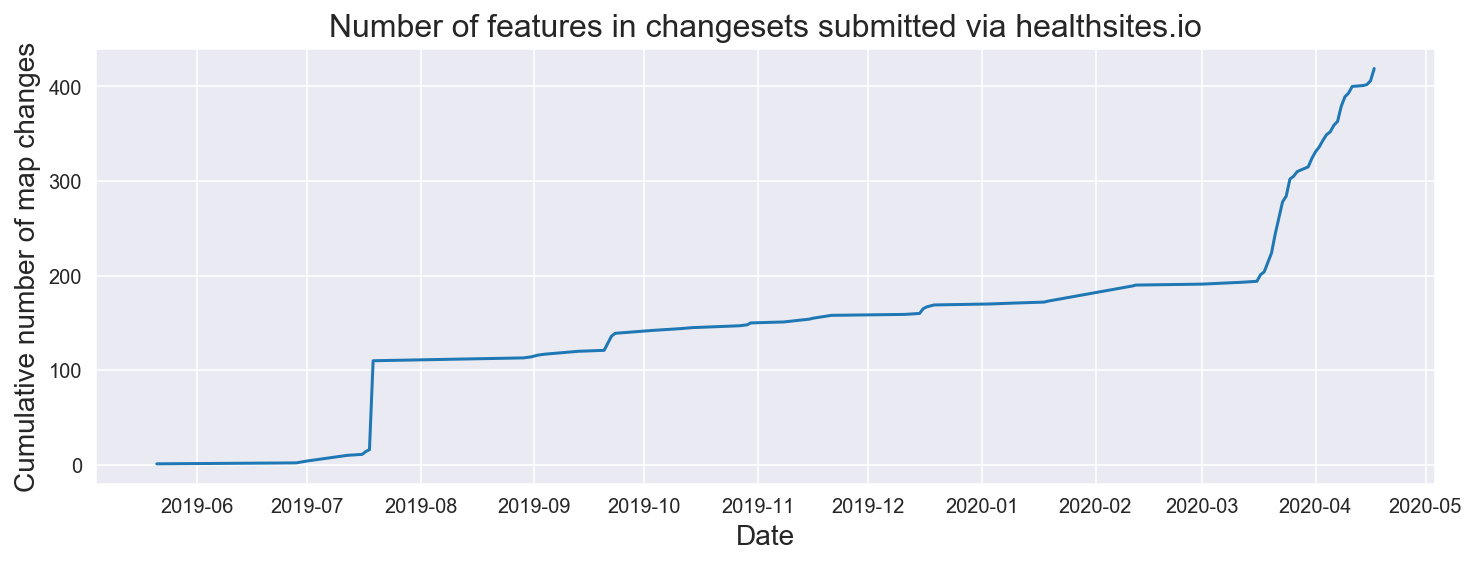

In [186]:
sns.set_style('darkgrid')
# healthsites.groupby('date').agg('count')['id'].plot(ax=ax1, style='.')
ax = healthsites.groupby('date').agg('sum').cumsum()['num_changes'].plot(figsize=(12,4))
ax.set_title("Number of features in changesets submitted via healthsites.io", fontsize=16)
ax.set_xlabel("Date", fontsize=14); ax.set_ylabel("Cumulative number of map changes", fontsize=14);

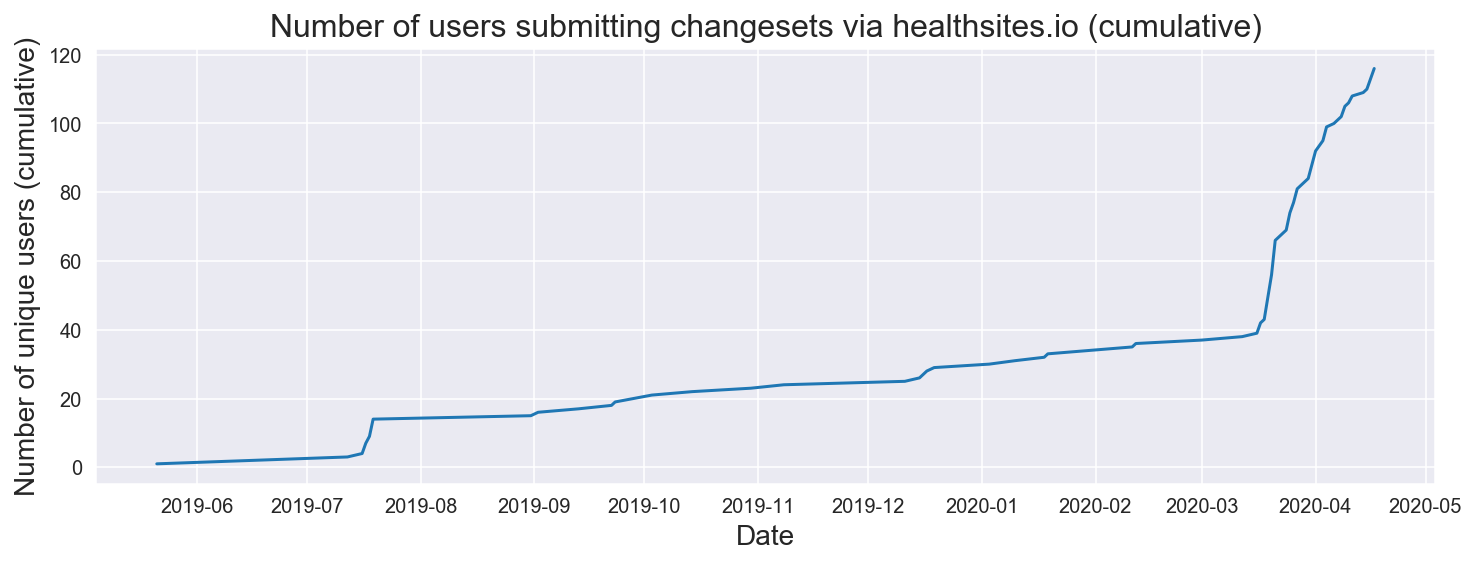

In [155]:
sns.set_style('darkgrid')
# healthsites.groupby('date').agg('count')['id'].plot(ax=ax1, style='.')
ax = healthsites.groupby('user').agg(min).groupby('date').agg('count')['id'].cumsum().plot(figsize=(12,4))
ax.set_title("Number of users submitting changesets via healthsites.io (cumulative)", fontsize=16)
ax.set_xlabel("Date", fontsize=14); ax.set_ylabel("Number of unique users (cumulative)", fontsize=14);

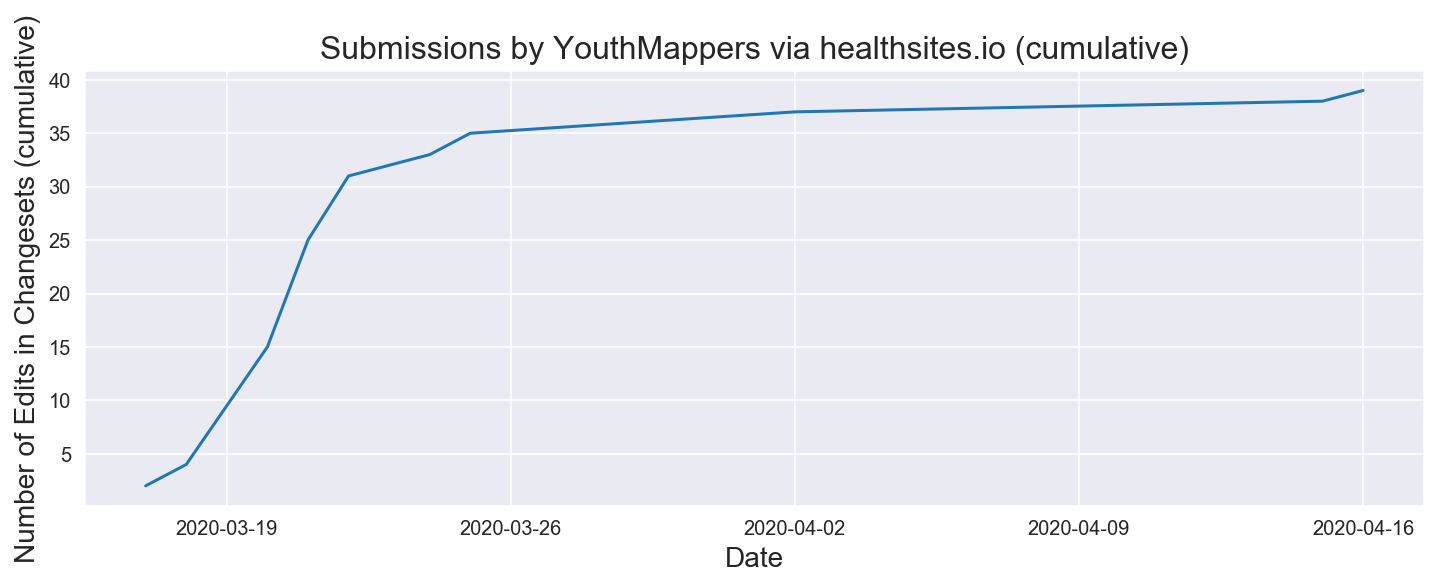

In [156]:
ax = healthsites[healthsites.is_ym].groupby('date').agg('sum').cumsum()['num_changes'].plot(figsize=(12,4))
ax.set_title("Submissions by YouthMappers via healthsites.io (cumulative)", fontsize=16)
ax.set_xlabel("Date", fontsize=14); ax.set_ylabel("Number of Edits in Changesets (cumulative)", fontsize=14);

So that was from changsets that have `healthsite` in the created_by tag. If we instead search for YouthMappers in the comments, what do we find?

```sql
SELECT *,
FROM changesets
WHERE lower(tags['comment']) LIKE '%healthsite%' AND lower(tags['comment']) LIKE '%youthmapper%'
```

Returns only [this changeset](https://www.openstreetmap.org/changeset/82365239).

Furthermore, searching for changesets with `youthmapper` and `map4covid` also return fewer results than the above approach of matching our known list of usernames to all of the changesets submitted via healthsites.io.
    

To confirm these results, this query:
    
```sql
SELECT count(id),
       min(created_at) AS first_changeset, 
       max(created_at) AS last_changeset,
       count(distinct(uid)) AS number_of_users,
       sum(num_changes) AS total_map_changes
FROM changesets
WHERE lower(tags['created_by']) LIKE '%healthsites%
```

Returns:


| count	| first_changeset	| last_changeset	| number_of_users	| total_map_changes
|-------|-------------------|-------------------|-------------------|------------------|
| 452	| 2019-05-21        | 2020-04-17        | 116	            | 419              | 


## Geospatial data belongs on a map, not in a dataframe

Visit https://townsendjennings.com/healthsites-io to see the map

In [157]:
#coordinal-sin
def cheap_point_calculator(row):
    if (not np.isnan(row.min_x) and
        not np.isnan(row.min_y) and
        not np.isnan(row.max_x) and
        not np.isnan(row.max_y) ):
        return shapely.geometry.Point(
            (row.min_x+row.max_x) / 2,
            (row.min_y+row.max_y) / 2
        )
    else:
        return None

In [158]:
healthsites['geometry'] = healthsites.apply(lambda row: cheap_point_calculator(row), axis=1)

to_map = gpd.GeoDataFrame(healthsites[pd.notnull(healthsites.geometry)])

In [159]:
map_1 = keplergl.KeplerGl(height=800)
map_1.add_data(data=to_map[to_map.is_ym][['geometry','created_at','user']], name="healthsites_by_ym")
map_1.add_data(data=to_map[~to_map.is_ym][['geometry','created_at','user']], name="healthsites_by_other")

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [160]:
map_1

KeplerGl(data={'healthsites_by_ym': {'index': [0, 1, 163, 168, 215, 216, 222, 223, 228, 229, 230, 234, 235, 23…

In [149]:
map_1.save_to_html(
    file_name='docs/index.html',
    read_only=True
)

Map saved to docs/index.html!
